In [140]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [141]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json
from glob import glob

In [142]:
torch.backends.cudnn.benchmark=True

## Data

In [143]:
PATH = Path('../data/Train')

In [144]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [145]:
VEHICLES=10
ROADS=7

In [146]:
TRAIN_DN = 'CameraRGB-128'
MASKS_DN = 'CameraSeg-128'
sz = 128
bs = 64
nw = 16

### Create dataloader

In [147]:
def convert_y(y_img):
    y_new = np.zeros(y_img.shape)
    y_new[y_img[:,:,2]==VEHICLES] = 1
    y_new[y_img[:,:,2]==ROADS] = 2
    return y_new.astype(np.int64)

In [148]:
def open_y_image(fn):
    """ Opens an image using OpenCV given the file path.

    Arguments:
        fn: the file path of the image

    Returns:
        The image in RGB format as numpy array of floats normalized to range between 0.0 - 1.0
    """
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        #res = np.array(Image.open(fn), dtype=np.float32)/255
        #if len(res.shape)==2: res = np.repeat(res[...,None],3,2)
        #return res
        try:
            im = cv2.imread(str(fn), flags)
            if im is None: raise OSError(f'File not recognized by opencv: {fn}')
#             return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#             return np.dstack((im[:,:,2]==ROADS, im[:,:,2]==VEHICLES, (im[:,:,2]!=VEHICLES) & (im[:,:,2]!=ROADS))).astype(np.float32)
            return convert_y(im)
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

In [149]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): 
        return open_y_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 3
    def get(self, tfm, x, y):
        x,y = super().get(tfm, x, y)
#         y = np.stack((y[0,:,:]==ROADS, y[0,:,:]==VEHICLES, (y[0,:,:]!=VEHICLES) & (y[0,:,:]!=ROADS)))
#         y = y[0].astype(np.int64)
#         print(y)
        return x,y[0]
#         return x,y.reshape(-1)

In [150]:
x_names = np.array(glob(str(PATH/TRAIN_DN/'*.png')))
y_names = np.array(glob(str(PATH/MASKS_DN/'*.png')))
print(len(x_names), len(y_names))

1000 1000


In [151]:
bs=2

In [152]:
VEHICLES=10
ROADS=7

In [153]:
val_idxs = list(range(100))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [154]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]

In [155]:
# tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms)
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path='')
md = ImageData(PATH, datasets, bs, num_workers=7, classes=None)
denorm = md.trn_ds.denorm

## Simple upsample

In [156]:
f = resnet34
cut,lr_cut = model_meta[f]

In [157]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [158]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [159]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [160]:
class Upsample34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.features = nn.Sequential(
            rn, nn.ReLU(),
            StdUpsample(512,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
#             nn.ConvTranspose2d(256, 1, 2, stride=2))
            nn.ConvTranspose2d(256, 3, 2, stride=2))
        
    def forward(self,x): 
#         print('Forward pass called')
        out = self.features(x)
#         print(out.shape)
#         xreshape = x.view(x.shape[0], x.shape[1], -1)
#         print(xreshape.shape)
        return F.log_softmax(out)

In [161]:
class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model.features)[1:]]

In [162]:
m_base = get_base()

In [163]:
m = to_gpu(Upsample34(m_base))
models = UpsampleModel(m)

## After testing

In [164]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.NLLLoss()
# learn.metrics=[accuracy_thresh(0.5),dice]
learn.metrics=[accuracy_thresh(0.5)]

In [165]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('BatchNorm2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_para

In [166]:
learn.freeze_to(1)

In [167]:
# %pdb on

 75%|███████▌  | 338/450 [00:08<00:02, 37.73it/s, loss=1.2]  


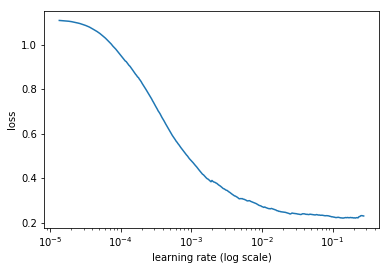

In [168]:
learn.lr_find()
learn.sched.plot()

In [169]:
lr=4e-2
wd=1e-7
lrs = np.array([lr/100,lr/10,lr])/2

In [ ]:
def accuracy_thresh(thresh):
    return lambda preds,targs: accuracy_multi(preds, targs, thresh)
def accuracy_multi(preds, targs):
    pdb.set_trace()
    return ((preds>0.5).float()==targs).float().mean()
def new_acc(preds, targs):
    mx,idx = torch.max(preds, 1)
    return (idx == targs).float().mean()

In [188]:
def dice(pred, targs):
#     pred = (pred>0).float()
    mx,idx = torch.max(pred, 1)
    pred = idx.float()
    targs = targs.float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [189]:
learn.metrics=[new_acc, dice]

In [190]:
learn.fit(lr,1, wds=wd, cycle_len=1,use_clr=(20,8))

  9%|▉         | 41/450 [00:01<00:11, 34.42it/s, loss=0.0573]
epoch      trn_loss   val_loss   new_acc    dice              
    0      0.05275    0.04213    0.982606   1.650343  



[array([0.04213]), 0.982606201171875, 1.6503430646772284]

In [ ]:
learn.save('tmp')

In [ ]:
learn.load('tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
learn.fit(lrs,1,cycle_len=4,use_clr=(20,8))

In [ ]:
learn.save('128')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
show_img(py[0]>0);

In [ ]:
show_img(y[0]);

## U-net (ish)

In [ ]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [ ]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [ ]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256,3,16)
        self.up6 = nn.ConvTranspose2d(16, 1, 1)
        
    def forward(self,x):
        inp = x
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, inp)
        x = self.up6(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [ ]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [ ]:
m_base = get_base()

In [ ]:
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [ ]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [ ]:
[o.features.size() for o in m.sfs]

In [ ]:
learn.freeze_to(1)

In [ ]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr=4e-2
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [ ]:
learn.fit(lr,1,wds=wd,cycle_len=8,use_clr=(5,8))

In [ ]:
learn.save('128urn-tmp')

In [ ]:
learn.load('128urn-tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
learn.fit(lrs/2, 1, wds=wd, cycle_len=10,use_clr=(20,10))

In [ ]:
learn.save('128urn-0')

In [ ]:
learn.load('128urn-0')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
show_img(py[0]>0);

In [ ]:
show_img(y[0]);

In [ ]:
m.close()

## 512x512

In [ ]:
TRAIN_DN = 'train'
MASKS_DN = 'train_masks_png'

In [ ]:
sz=512
bs=8

In [ ]:
x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [ ]:
val_idxs = list(range(1008))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [ ]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [ ]:
lr=2e-2
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [ ]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [ ]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [ ]:
learn.freeze_to(1)

In [ ]:
learn.load('128urn-0')

In [ ]:
learn.fit(lr,1,wds=wd, cycle_len=5,use_clr=(5,5))

In [ ]:
learn.save('512urn-tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
learn.load('512urn-tmp')

In [ ]:
learn.fit(lrs/2,1,wds=wd, cycle_len=8,use_clr=(20,8))

In [ ]:
learn.fit(lrs/2,1,wds=wd, cycle_len=8,use_clr=(20,8))

In [ ]:
learn.save('512urn')

In [ ]:
learn.load('512urn')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
show_img(py[0]>0);

In [ ]:
show_img(y[0]);

In [ ]:
m.close()

## 1024x1024

In [ ]:
sz=1024
bs=4

In [ ]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [ ]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [ ]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [ ]:
learn.load('512urn')

In [ ]:
learn.freeze_to(1)

In [ ]:
learn.fit(lr,1, wds=wd, cycle_len=2,use_clr=(5,4))

In [ ]:
learn.save('1024urn-tmp')

In [ ]:
learn.load('1024urn-tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
lrs = np.array([lr/200,lr/30,lr])

In [ ]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

In [ ]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

In [ ]:
learn.sched.plot_loss()

In [ ]:
learn.save('1024urn')

In [ ]:
learn.load('1024urn')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
show_img(py[0]>0);

In [ ]:
show_img(y[0]);